### **Project 1. Vertical Wind Velocity**

##### Object: Calculate vertical wind velocity and make a figure of zonally-averaged vertical wind velocity w

In [1]:
### 0. Calling packages 


import sys
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import netCDF4 as nc4
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, LogLocator, SymmetricalLogLocator, AutoMinorLocator)
from collections import OrderedDict

In [2]:
### 1. python의 netCDF4 모듈을 이용하여 하나의 .nc4 파일 읽기


rdir = '.'
fname = rdir+'/for_Q1_MERRA2_300.inst3_3d_asm_Np.20020512.nc4'
dataset = nc4.Dataset(fname, 'r')

dataset


# 이렇게 그냥 'dataset'을 치면 해당 데이터에 대한 정보가 출력되므로 본격적인 계산을 수행하기 전 읽어보는 것이 좋음
# ex. 축에 대한 정보, spatial resolution, time resolution, 변수 개수와 종류 등

# 해당 데이터 파일이 위치한 폴더로 이동한 후 터미널에 'ncdump -c 파일명'을 입력하고 엔터를 치면 더 자세한 정보를 알 수 있음
# 여기서는 'ncdump -c for_Q1_MERRA2_300.inst3_3d_asm_Np.20020512.nc4'라고 입력하면 됨

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    History: Original file generated: Mon Jul  7 19:06:30 2014 GMT
    Comment: GMAO filename: d5124_m2_jan00.inst3_3d_asm_Np.20020512.nc4
    Filename: MERRA2_300.inst3_3d_asm_Np.20020512.nc4
    Conventions: CF-1
    Institution: NASA Global Modeling and Assimilation Office
    References: http://gmao.gsfc.nasa.gov
    Format: NetCDF-4/HDF-5
    SpatialCoverage: global
    VersionID: 5.12.4
    TemporalRange: 1980-01-01 -> 2016-12-31
    identifier_product_doi_authority: http://dx.doi.org/
    ShortName: M2I3NPASM
    GranuleID: MERRA2_300.inst3_3d_asm_Np.20020512.nc4
    ProductionDateTime: Original file generated: Mon Jul  7 19:06:30 2014 GMT
    LongName: MERRA2 inst3_3d_asm_Np: 3d,3-Hourly,Instantaneous,Pressure-Level,Assimilation,Assimilated Meteorological Fields
    Title: MERRA2 inst3_3d_asm_Np: 3d,3-Hourly,Instantaneous,Pressure-Level,Assimilation,Assimilated Meteorological Fields
  

In [3]:
### 2-1. 읽은 파일에서 축에 대한 정보를 읽어 저장하기


lon = (dataset.variables['lon'])[:]
lat = (dataset.variables['lat'])[:]
lev = (dataset.variables['lev'])[:]
tim = (dataset.variables['time'])[:]

/tmp/ipykernel_649/680112101.py:7: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  tim = (dataset.variables['time'])[:]


In [4]:
### 2-2. 읽은 파일에서 변수에 대한 정보를 읽어 저장하기

u = (dataset.variables['U'])[:]
v = (dataset.variables['V'])[:]
omega = (dataset.variables['OMEGA'])[:]
T = (dataset.variables['T'])[:]
SLP = (dataset.variables['SLP'])[:]
EPV = (dataset.variables['EPV'])[:]

In [5]:
### Q1-1. 해당 데이터는 변수 별로 각각 몇 차원이며, 각 axis의 크기는 얼마나 될까?


# lon: 1차원, 576
# lat: 1차원, 361
# lev: 1차원, 42
# tim: 1차원, 8

# u: 4차원, 8*42*361*576
# v: 4차원, 8*42*361*576
# omega: 4차원, 8*42*361*576
# T: 4차원, 8*42*361*576
# SLP: 3차원, 8*361*576
# EPV: 4차원, 8*42*361*576

In [6]:
### Q1-2. 해당 데이터의 spatial resolution은 얼마인가?


# 0.5 x 0.625 (42 pressure levels)

In [7]:
### Q1-3. 해당 데이터의 time resolution은 얼마인가?


# 3-Hourly

In [8]:
### Q1-4. 위에서 읽은 변수들 중, 'OMEGA', 'SLP'는 각각 무엇을 의미하는가?


# OMEGA: vertical pressure velocity
# pressure coordinates, 즉 기압을 수직축으로 가지는 좌표계에서의 vertical velocity
# dp/dz = -ρg 라는 정역학 방정식을 dp/dt = -ρgdz/dt 와 같이 변형했을 때 좌변의 dp/dt가 omega에 해당


# SLP: sea level pressure

In [9]:
### Q1-5. 간단한 log-pressure height 식에 따르면, 압력과 고도 z는,

#         z = -H*ln(p/Ps)

#         의 관계로 나타낼 수 있다. (hydrostatic equation을 통해 유도 가능)
#         이 식에서 scale height H = 7 km, standard pressure Ps = 1000 hPa로 가정하자. 
#         위 식과 데이터를 통해 압력에서 z(m)에 대한 값을 계산하여 array로 저장하라.


# 첫 번째 풀이

y = []

for i in lev:
    z = -7000. * np.log(i/1000.)
    y.append(z)

print(y)


# 피드백

# 1. 값 자체는 맞으나 이 문제에서의 목표는 numpy의 적극적인 활용
# 2. 전 지구의 모든 3차원 지점 그리고 모든 시간대에서의 고도를 표시해야 하므로 z에 대한 array는 똑같이 tim, lev, lat, lon의 4차원 데이터로 만들어야 함
# 3. dimension 하나에 대해서만 변수가 dependent할 때 반복문을 통해 어떻게 넣어줄 것인가를 학습하는 것이 목표

[-0.0, 177.22465589002928, 359.05306071285406, 545.7307902879827, 737.5236096047839, 934.7197483716584, 1137.6325064844245, 1346.603248532193, 1562.004859199468, 1784.2457474015303, 2013.7745071624663, 2251.085368892236, 2496.7246075711273, 3015.4804126471795, 3575.779366361935, 4184.859005289343, 4852.030263919617, 5589.553873524402, 6414.035123119085, 7348.754871490745, 8427.809630281552, 9704.060527839234, 11266.065387038701, 13279.83989420117, 16118.095650958317, 18614.820258529446, 20970.125914877935, 22532.130774077403, 24545.905281239873, 27384.161037997023, 32236.191301916635, 34732.91590948776, 37088.221565836255, 38650.226425035726, 40664.00093219819, 43502.25668895534, 48354.28695287496, 50851.01167965538, 53206.317216794574, 54768.32197168592, 56782.096305001505, 64472.382499525156]


In [10]:
### Q1-5. 간단한 log-pressure height 식에 따르면, 압력과 고도 z는,

#         z = -H*ln(p/Ps)

#         의 관계로 나타낼 수 있다. (hydrostatic equation을 통해 유도 가능)
#         이 식에서 scale height H = 7 km, standard pressure Ps = 1000 hPa로 가정하자. 
#         위 식과 데이터를 통해 압력에서 z(m)에 대한 값을 계산하여 array로 저장하라.


# 두 번째 풀이


z = np.zeros([8, 42, 361, 576])

for i in range(42):
    z[:, i, :, :] = -7000. * np.log(lev[i]/1000.)

print(z)

[[[[   -0.            -0.            -0.         ...    -0.
       -0.            -0.        ]
   [   -0.            -0.            -0.         ...    -0.
       -0.            -0.        ]
   [   -0.            -0.            -0.         ...    -0.
       -0.            -0.        ]
   ...
   [   -0.            -0.            -0.         ...    -0.
       -0.            -0.        ]
   [   -0.            -0.            -0.         ...    -0.
       -0.            -0.        ]
   [   -0.            -0.            -0.         ...    -0.
       -0.            -0.        ]]

  [[  177.22465589   177.22465589   177.22465589 ...   177.22465589
      177.22465589   177.22465589]
   [  177.22465589   177.22465589   177.22465589 ...   177.22465589
      177.22465589   177.22465589]
   [  177.22465589   177.22465589   177.22465589 ...   177.22465589
      177.22465589   177.22465589]
   ...
   [  177.22465589   177.22465589   177.22465589 ...   177.22465589
      177.22465589   177.22465589]
  

In [11]:
### Q1-6. 이상기체상태방정식을 이용하여 압력고도에 따른 밀도 ρ(p)를 구하고자 한다. 
#         ρ에 대한 array 를 만들어 저장하라. (mean surface air density ρ(p = 1000) = 1.225 kg/m3,
#         건조공기에 대한 기체상수 R* = 287. J/kg/K 로 가정)


# PV = nRT 에서 R* = R / M 이라 하면, PV = nR*MT = mR*T 이고,
# P = m/V * R* T = ρR*T 라는 관계식을 얻을 수 있다.


rho = np.zeros([8, 42, 361, 576])

for i in range(42):
    rho[:, i, :, :] = (lev[i]*100.) / (287. * T[:, i, :, :])

print(rho)

[[[[3.48432068e+02 3.48432068e+02 3.48432068e+02 ... 3.48432068e+02
    3.48432068e+02 3.48432068e+02]
   [3.48432068e+02 3.48432068e+02 3.48432068e+02 ... 3.48432068e+02
    3.48432068e+02 3.48432068e+02]
   [3.48432068e+02 3.48432068e+02 3.48432068e+02 ... 3.48432068e+02
    3.48432068e+02 3.48432068e+02]
   ...
   [1.29667962e+00 1.29668665e+00 1.29669595e+00 ... 1.29665828e+00
    1.29666543e+00 1.29667246e+00]
   [1.29828370e+00 1.29829323e+00 1.29830027e+00 ... 1.29825783e+00
    1.29826486e+00 1.29827440e+00]
   [1.30012405e+00 1.30012405e+00 1.30012405e+00 ... 1.30012405e+00
    1.30012405e+00 1.30012405e+00]]

  [[3.39721252e+02 3.39721252e+02 3.39721252e+02 ... 3.39721252e+02
    3.39721252e+02 3.39721252e+02]
   [3.39721252e+02 3.39721252e+02 3.39721252e+02 ... 3.39721252e+02
    3.39721252e+02 3.39721252e+02]
   [3.39721252e+02 3.39721252e+02 3.39721252e+02 ... 3.39721252e+02
    3.39721252e+02 3.39721252e+02]
   ...
   [1.27146554e+00 1.27151203e+00 1.27155852e+00 ... 1.27

In [12]:
### Q1-7. Hydrostatic equation에서 vertical pressure velocity omega와 vertical velocity의 관계식을 유도하고,
#         데이터 내의 OMEGA를 통해 w를 계산하여 array로 저장하라.


w = np.zeros([8, 42, 361, 576])

w = -omega / (rho * 9.8)

print(w)

[[[[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   ...
   [0.0018163971361290178 0.0018163872838232792 0.001821177294790076
    ... 0.0018116238522554347 0.001811613859127492
    0.0018116040326591866]
   [0.0012576821184871383 0.0012528757533290227 0.0012480718653212167
    ... 0.0012673016935158675 0.0012624975963480623
    0.0012624883224107949]
   [0.0002451334602079438 0.0002451334602079438 0.0002451334602079438
    ... 0.0002451334602079438 0.0002451334602079438
    0.0002451334602079438]]

  [[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   ...
   [0.00225154663050351 0.0022563624709827663 0.0022562799722607094 ...
    0.002246878116885 0.00225169483184975 0.002251628962176205]
   [0.00162388153301633 0.0016189497250741472 0.0016091336554423725 ...
    0.0016386542959902412 0.0016337338546930126 0.0016288016504244572]
   [0.0005903379892639683 0.0005903379892639683 0.0005903379892639683
    ... 0.000590337989263968

In [13]:
### Q1-8. vertical velocity w 를 zonally averaging 하여 저장하라.
#         zonally-averaged vertical velocity w 의 dimension은 몇차원이며, 그 size는 어떠한가?


w_avg = np.mean(w, axis=3)

print(np.shape(w_avg))

# 3차원, 8*42*361

(8, 42, 361)


In [14]:
### 전체적인 유의사항 ###


# 1. 상수 표시할 때 실수면 확실하게 소수점까지 표시하기

# 2. 단위에 항상 유의

# 3. 초기 계산값은 SI단위로 계산하는 습관을 들이기

# ex1. 길이/거리의 경우 km가 아니라 SI단위인 m를 우선적으로 사용하고,
# 나중에 그림 그리는 단계에서 km 단위로 나타내야 한다면 /1000을 하는 등의 방법을 사용하면 단위 때문에 꼬이는 일이 적음

# ex2. Q1-5에서 엄밀하게는 i값도 lev에 hPa로 저장되어 있으므로, SI단위인 Pa로 바꿔주는 게 맞으나, 나누는 값인 표준기압 1000의 단위가 hPa라서 상관 없게 됨.

# ex3. Q1-5에서는 별 문제가 안 생겼었지만, Q1-6에서는 단위에 주의했어야 했음. lev에는 SI단위인 Pa가 아니라 hPa 단위로 데이터가 저장되어 있음.


### TIP ###


# 다음과 같이 자주 사용되는 상수들은 정의를 해준 다음 가져다 쓰는 것이 훨씬 효율적임.
# 만약 습한 날이라 기체 상수를 바꿔줘야 하는 등의 상황이 생기면 내가 짠 코드는 수정하기에 번거로울 수 있음.

g = 9.81           # 중력가속도
R = 287.           # 건조공기에 대한 specific air constant
H = 7000.          # scale height (m)
Ps = 1000.         # 표준기압 Ps (hPa)

In [15]:
### Q2. Q1에서 구한 zonally-averaged vertical velocity w 를 latitude-height 그림으로 그려 나타내라. (UTC 03에 대해)

#       * 다음 항목은 그림에 반드시 나타낼 것

#         (a) x축 90°S ~ 90°N 범위 30°단위로 tick을 나타낼 것.
#         (b) y축 아래쪽부터 1000 hPa ~ 1 hPa, y축은 scale을 log scale로 나타내고,
#             tick은 1000, 500, 200, 100, 50, 20, 10, 5, 2, 1 hPa에서 표시할 것.
#         (c) 그림 제목을 반드시 포함
#         (d) 그림 아래쪽에 colorbar를 그릴 것, colorbar 색 간격은 자유롭게 특징이 잘 나타나도록 할 것,
#             colorbar에 w의 단위를 표시할 것.

In [16]:
# UTC 03에 대해서 w를 latitude-height 그림으로 나타낼 것이므로, time dimension에서 index를 1번으로 설정해 준다
# 시간 간격이 3시간이므로 00, 03, 06, ... 이런 식으로 진행될 것이기 때문


w_avg_03 = w_avg[1, :, :] * 100.
print(np.shape(w_avg_03))


# 단위에 항상 유의하자! vertical velocity w의 단위는 m/s인데, 그림 그릴 때는 cm/s 단위로 표현할 예정이라서 *100.을 해준 것임
# 그리고 항상 실수 표기 잊지 말자! 100. 이렇게

(42, 361)


In [17]:
print(np.max(w_avg_03))
print(np.min(w_avg_03))

1.8763091292424392
-4.927488918606114


/tmp/ipykernel_649/1894703840.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_ticks])


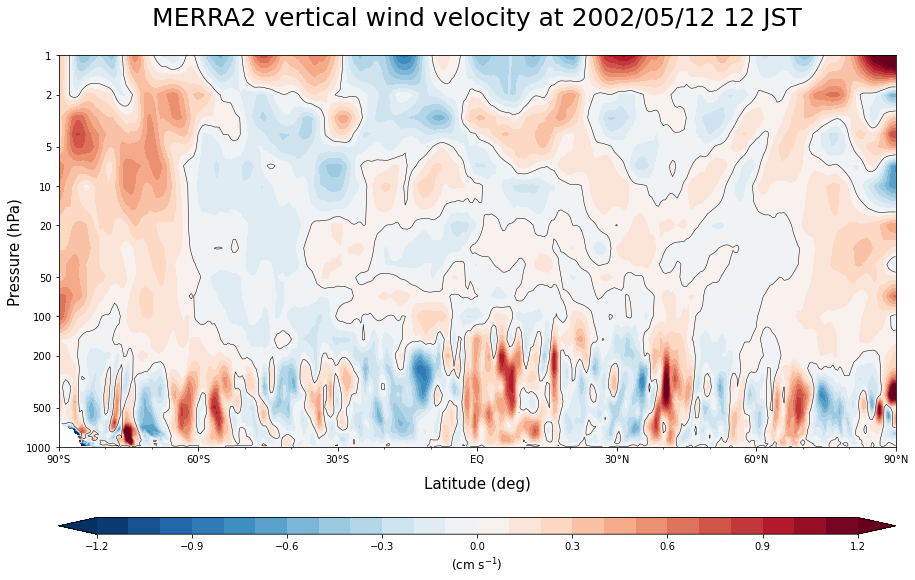

In [18]:
# figure 틀 잡아주기

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()


# 대제목과 소제목 설정하기

plt.title('MERRA2 vertical wind velocity at 2002/05/12 12 JST', fontsize = 25, pad = 30)


# contourf를 통해 전체적인 그림을 생성하고, x축과 y축 라벨 지정하기

w_fig = plt.contourf(lat, lev, w_avg_03, levels = np.arange(-1.2, 1.21, 0.1), cmap = 'RdBu_r', extend = 'both')
plt.xlabel('Latitude (deg)', fontsize = 15, labelpad = 12)
plt.ylabel('Pressure (hPa)', fontsize = 15)


# 그냥 그림을 그리면 y축에서 아랫부분이 1, 윗부분이 1000으로 나타나므로 뒤집어주고, 범위 지정해주기

# plt.gca().invert_yaxis() 이거 굳이 안 쓰고 ylim(1000, 1)만 해줘도 축이 알아서 뒤집힘
plt.ylim(1000, 1)


# 그냥 그림을 그리면 y축 윗부분에서 눈금이 겹쳐 보이는 문제가 발생하므로 log scale로 바꿔주고, 지수 형식으로 표시되는 눈금을 정수형으로 바꿔주기

plt.yscale("log")
current_ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_ticks])


# y축 눈금 설정해주기(자동 생성되는 보조 눈금 제거, 주 눈금에 라벨링하기)

plt.minorticks_off()
plt.yticks([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))) # 이 방법은 핵폭탄으로 개미 잡은 격..


# 핵폭탄으로 개미 잡기 대신 간단한 풀이
# 해당 줄 대신에 아래 코드 사용하기

# ax.set_yticks([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
# ax.set_yticklabels(['1','2','5','10','20','50','100', '200', '500', '1000'])


# x축 눈금 설정해주기(10의 배수마다 보조 눈금 생성, 주 눈금에 라벨링하기)

ax.xaxis.set_minor_locator(MultipleLocator(10))
plt.xticks([-90, -60, -30, 0, 30, 60, 90], labels = ['90°S', '60°S', '30°S', 'EQ', '30°N', '60°N', '90°N'])


# colorbar 설정하기

clb = plt.colorbar(w_fig, orientation = 'horizontal', aspect = 50, pad = 0.13)
clb.set_label('(cm s$^{-1}$)', fontsize = 12)

# plt.colorbar 매뉴얼을 읽어보면, 괄호 안 맨 처음 항목에 들어가는 게 mappable, 즉 컬러바가 나타내는 그래프
# 그래서 사실 colorbar의 경우 그림을 그려놓으면 괄호 안에 그림 이름만 넣어도 거기에 맞게 그림을 그리기 때문에,
# tick이나 extend를 colorbar에서 지정해줄 필요가 없음. 그래서 처음에 colorbar 안에 tick, extend와 같은 항목들 넣어놨다가 contourf로 옮김.


# contour 설정하기(0cm/s에서만 표현되도록, -1.2에서 1.2까지의 범위를 벗어나는 값에 대해서는 표현되지 않도록)

# plt.contour(lat, lev, w_avg_03, levels = np.arange(-1.2, 1.2, 1.2), linewidths=0.5, colors = 'black')
# 윗부분이 원래 쓴 코드인데, 아래 주석처리 안 된 코드처럼 levels 뒤에 xticks, yticks 적듯이 리스트 적어주면 그거대로 그림.
# levels 안에 np.arange를 넣는 것도 array를 생성하기 위함.
# 아래 코드는 w = 0.인 지점을 따라 contour를 그리라는 의미

plt.contour(lat, lev, w_avg_03, levels = [0.], linewidths=0.5, colors = 'black')